### Import des packages que nous allons utiliser au cours de ce notebook

In [1]:
%matplotlib inline


In [2]:
import matplotlib
import matplotlib.pyplot as plt, mpld3
from matplotlib.ticker import FuncFormatter
from mpld3 import plugins
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 250)
pd.set_option('precision', 0)

In [3]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource

Nous importons le package d'OpenFisca-France ainsi que certains sous-packages spécifiques nécessaire à l'exécution du notebook.

In [4]:
#Specific usage imports
from openfisca_core import periods, rates
import openfisca_france

Nous importons le `tax-benefit-system` et créons des fonctions afin de simuler des scénarios (ou cas types) qui nous servirons pour les simulations.

In [5]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

In [6]:
ax_variable_max = 280000
ax_variable_min = 30_000
count = 10000

year_lag_max = 4
def make_scenario(couple = True, mar_pacs = True, nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = ax_variable_min,
                                    count = count,count_span = None, age = 12, salaire_de_base_conjoint = 0):
    if mar_pacs: assert couple == True
    if count is None: count =  (ax_variable_max - ax_variable_min)/count_span #Fais une simulation par tranche de 10 euros brut
    
    enfant = [dict(age = age)]
    enfants = enfant * nombre_enfants
    
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [dict(count = count, 
                  min = ax_variable_min,
                  max = ax_variable_max,
                  name = axes_variable,
                  period = year-fill_lag) for fill_lag in range(year_lag_max)]
            ],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = u"pacse",
            ) if mar_pacs else dict(
            age = 40,
            ppe_du_sa = 6020, statut_marital = u"celibataire" 
            ),
        parent2 = dict(age = 40,ppe_du_sa = 6020,statut_marital = "pacse", salaire_de_base = salaire_de_base_conjoint) if mar_pacs else (dict(age = 40,ppe_du_sa = 6020,salaire_de_base = salaire_de_base_conjoint, statut_marital = u"celibataire") if couple == True else None) ,
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = "locataire_vide",
            depcom = 13012,
            ),
        foyer_fiscal = dict(
            f7ea = nombre_enfants * ((age<15) * age>=11), #Nombre enfants à charge poursuivants leurs études : collège
            f7ec = nombre_enfants * ((age<19) * age>=15), #Nombre enfants à charge poursuivants leurs études : lycée
            f7ef = nombre_enfants * ((age<26) * age>=19), #Nombre enfants à charge poursuivants leurs études : Enseignement supérieur
            caseT = False if couple == True else True * (nombre_enfants>0)# Warning ! TODO: mieux gérer, à priori pose pas de problème si True avec un couple marié...
            ),
        )

    if (couple == True) and (mar_pacs==False):
        test_case = scenario.test_case
        test_case["foyers_fiscaux"][0]['declarants']  = ['ind0']
        test_case["foyers_fiscaux"].append({'declarants': ['ind1'],'id': 1,'caseT': False })
        scenario.test_case = test_case
        return scenario
    else:
        return scenario
        
        


In [7]:

simulation_dict = dict()
for nb_enf in range(0,7):
    simulation_dict[nb_enf] = dict()
    for year in range(2007,2016): 
        simulation_dict[nb_enf][year] = make_scenario(couple = True,mar_pacs=True,nombre_enfants=nb_enf,year = year, count= 1000).new_simulation()

In [8]:
simulation_dict_single = dict()
for nb_enf in range(0,6):
    simulation_dict_single[nb_enf] = dict()
    for year in range(2010,2016): 
        simulation_dict_single[nb_enf][year] = make_scenario(couple = False, mar_pacs=False, nombre_enfants=nb_enf,year = year, count=1000).new_simulation()

In [9]:
import pandas as pd
import bokeh
from bokeh.plotting import figure
from bokeh.sampledata.stocks import AAPL

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
import bokeh.models as pltm
output_notebook()

Loading BokehJS ...

In [10]:
#avantage_qf_2011 = simulation_dict[6][2011].calculate("avantage_qf", period = 2011)
#avantage_qf_2013 = simulation_dict[6][2013].calculate("avantage_qf", period = 2013)
#print(avantage_qf_2011[104])
#print(avantage_qf_2013[104])
#print(avantage_qf_2011[104]-avantage_qf_2013[104])
#print((avantage_qf_2011-avantage_qf_2013)[104])
#print((simulation_dict[6][2011].calculate_add("avantage_qf", period = 2011)- \
#      simulation_dict[6][2014].calculate_add("avantage_qf", period = 2014))[104])

In [11]:
source_dict_2011 = dict()
for child in range(6):
    avantage_qf_2011 = simulation_dict[child][2011].calculate("avantage_qf", period = 2011)
    avantage_qf_2013 = simulation_dict[child][2013].calculate("avantage_qf", period = 2013)
    reform_cost = avantage_qf_2011 - avantage_qf_2013
    revdisp = simulation_dict[child][2013].calculate("revenu_disponible", period = 2013)
    share_of_disposable_income = reform_cost/revdisp
    df = pd.DataFrame({'rbg':simulation_dict[child][2011].calculate("rbg", period = 2011),
                       'irpp': - simulation_dict[child][2011].calculate("irpp", period = 2011),
                       'decote':  simulation_dict[child][2011].calculate("decote_gain_fiscal", period = 2011),
                       'avantage_qf':simulation_dict[child][2011].calculate("avantage_qf", period = 2011),
                       'avantage_qf_2013':simulation_dict[child][2013].calculate("avantage_qf", period = 2013),
                       'child_number':simulation_dict[child][2013].calculate_add("nb_pac", period = 2013),
                       'reform_cost': reform_cost,
                       'share_of_D_income': share_of_disposable_income*100,
                      })
    source = ColumnDataSource(data=df)
    source_dict_2011[child] = source

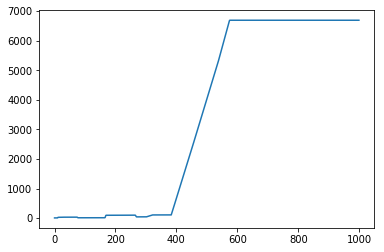

In [12]:
plt.plot(reform_cost)

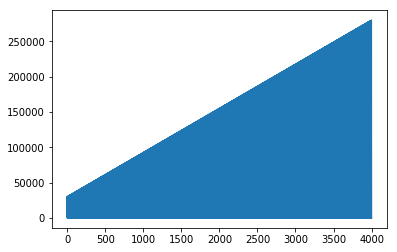

In [13]:
plt.plot(simulation_dict[2][2011].calculate_add("salaire_de_base", period = 2011))

In [14]:
#df[350:400]

In [15]:
source_dict_2013 = dict()
for child in range(6):
    avantage_qf_2011 = simulation_dict[child][2011].calculate("avantage_qf", period = 2011)
    avantage_qf_2013 = simulation_dict[child][2013].calculate("avantage_qf", period = 2013)
    reform_cost = avantage_qf_2011 - avantage_qf_2013
    share_of_disposable_income = reform_cost/simulation_dict[child][2013].calculate("revenu_disponible", period = 2013)
    df = pd.DataFrame({'rbg':simulation_dict[child][2013].calculate("rbg", period = 2013),
                       'irpp': - simulation_dict[child][2013].calculate("irpp", period = 2013),
                       'decote':  simulation_dict[child][2013].calculate("decote_gain_fiscal", period = 2013),
                       'avantage_qf':simulation_dict[child][2013].calculate("avantage_qf", period = 2013),
                       'salaire_imposable':simulation_dict[child][2013].calculate_add("salaire_imposable", period = 2013)[::child+2],
                       'child_number':simulation_dict[child][2013].calculate_add("nb_pac", period = 2013),
##Bug je ne sais        #'reform_cost' : simulation_dict[child][2011].calculate_add("avantage_qf", period = 2011)\
##Pourquoi              #            - simulation_dict[child][2014].calculate_add("avantage_qf", period = 2014)
                       'reform_cost': reform_cost,
                       "revdisp": revdisp,
                       'share_of_D_income': share_of_disposable_income*100,
                      })
    source = ColumnDataSource(data=df)
    source_dict_2013[child] = source

In [16]:
df[100:]

,rbg,irpp,decote,avantage_qf,salaire_imposable,child_number,reform_cost,revdisp,share_of_D_income
100,40478,-0,243,2725,44975,5,13,54761,2e-02
101,40664,-0,253,2740,45182,5,13,54962,2e-02
102,40850,-0,263,2756,45389,5,13,55162,2e-02
103,41037,-0,273,2772,45597,5,13,55362,2e-02
104,41224,-0,284,2788,45804,5,13,55562,2e-02
105,41410,-0,294,2804,46011,5,13,55762,2e-02
106,41597,-0,304,2820,46219,5,13,55963,2e-02
107,41783,-0,314,2835,46426,5,13,56163,2e-02
108,41970,-0,325,2851,46633,5,13,56363,2e-02
109,42156,-0,335,2867,46840,5,13,56563,2e-02


In [17]:
df.share_of_D_income.max()

4.975064

In [18]:

import jinja2
from bokeh.embed import components

# IMPORTANT NOTE!! The version of BokehJS loaded in the template should match 
# the version of Bokeh installed locally.

template = jinja2.Template("""
<!DOCTYPE html>
<html lang="en-US">

<link
    href="https://cdn.pydata.org/bokeh/release/bokeh-{0}.min.css"
    rel="stylesheet" type="text/css"
>
<script 
    src="https://cdn.pydata.org/bokeh/release/bokeh-{0}.min.js"
></script>

<body>

    
    {{{{ script }}}}
    
    {{{{ div }}}}

</body>

</html>
""".format(bokeh.__version__))
p = figure(width=1000, height=500, title='Hover over points')

In [19]:
TOOLTIPS = """
    <div>
        <div class="container-fluid">
            
            <span style="font-size: 15px; font-weight: bold;">@child_number{0,0.} 👶: <br></span>
            <span style="font-size: 15px ;">   &nbsp  Income: @rbg{0,0.} € <br></span>
            <span style="font-size: 15px ;">   &nbsp  Tax: @irpp{0,0.} €</span>
            <span style="font-size: 15px ;">   &nbsp  Avantage_qf: @avantage_qf{0,0.} € <br></span>
 

            <span style="font-size: 15px ;">   &nbsp  Reform cost: @reform_cost{0,0.} €</span>
            <span style="font-size: 15px ;">   &nbsp  Share of Disposable Income: @share_of_D_income{0,0.00}% <br></span>
            
    </div>
"""

In [20]:
from bokeh.models import Range1d
from bokeh.models import NumeralTickFormatter
p = figure(width=100, height=50, title='Fiscal gain from FQ',tooltips = TOOLTIPS)

#p.add_tools(pltm.HoverTool(tooltips=TOOLTIPS, mode = "vline")
#            )



for child in range(1,4):
    p.line(x='rbg', y='avantage_qf', source=source_dict_2013[child], line_color="blue", legend = "2013")
for child in range(1,4):
    p.line(x='rbg', y='avantage_qf', source=source_dict_2011[child], line_color="red", legend = "2011")
p.sizing_mode = "scale_width"
p.x_range=Range1d(40_000, 100_000)
p.xaxis.formatter = NumeralTickFormatter(format=u"0")
p.yaxis.axis_label = "Fiscal gain in euros"
p.xaxis.axis_label = "Taxable income in euros"
p.legend.location = "top_left"

show(p)
script, div = components(p)

In [21]:
file2  = open("/Users/adrienpacifico/Informatique/adrienpacifico.github.io/docs/bokeh_graph.html", "w")
file2.write(template.render(script=script, div=div)) 
file2.close()
from bokeh.io import reset_output
#reset_output()

In [22]:
from IPython.display import HTML
HTML(template.render(script=script, div=div))
